<center> <h1> Classify TAG Households into Income Percentiles </h1> </center>


## Table of Contents
1. [Library Imports](#Library-Imports)
2. [Import Data](#Import-Data)
3. [Sampling Frame](#Sampling-Frame)
4. [Feature Selection](#Feature-Selection)
5. [Income: Response Variable](#Income:-Response-Variable)
6. [Inference Methods](#Inference-Methods)
7. [Feature Engineering](#Feature-Engineering)
8. [Models](#Models)

## Library Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import us 
import datetime as dt
import string
import copy

from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import metrics 
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

## Import Data

In [143]:
tag = pd.read_stata("tag/TAG Survey_Data_18 Sept 2019.dta")
ihds = pd.read_stata("ihds/IHDS 2/DS0002/36151-0002-Data.dta")
ihds.columns = map(str.lower, ihds.columns) # Lower Case all Column Names

## Sampling Frame

* I need to figure out the variable to choose for the sampling frame. For now, I will continue with the entire IHDS Data Set. Currently, I will organize my code and ensure generality. Note: These girls are in the age range 15-20 unlike in TAG where the age range is 13-20.

Text(0.5, 0, 'No. of teenage girls')

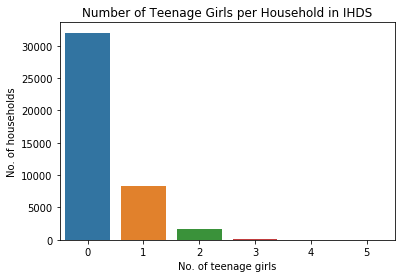

In [144]:
x = np.arange(0, len(np.array(ihds['nteenf'].value_counts())))
y = np.array(ihds['nteenf'].value_counts())
sns.barplot(x, y)
plt.title("Number of Teenage Girls per Household in IHDS")
plt.ylabel("No. of households")
plt.xlabel("No. of teenage girls")

In [145]:
ihds_sf = ihds[ihds['nteenf'] > 0]

In [146]:
print("Size of IHDS: " + str(len(ihds)))
print("Size of IHDS Sampling Frame: " + str(len(ihds_sf)))

Size of IHDS: 42152
Size of IHDS Sampling Frame: 10124


## Feature Selection


### 1. Household Assets

In [147]:
tag_asset_array = ['Electricity', 'Mattress', 'Pressure Cooker', 'Chair', 'Cot/Bed', \
          'Table', 'Electric Fan', 'Radio/Transistor', 'Black and White TV', 'Color TV', \
          'Sewing Machine', 'Mobile Telephone', 'Landline Telephone', 'Internet', \
          'Computer/Laptop', 'Refrigerator', 'AC', 'Washing Machine', 'Watch/Clock', \
          'Bicycle', 'Motorcycle/Scooter', 'Animal Drawn Cart', 'Car', 'Water Pump', \
          'Thresher', 'Tractor']
tag_variables = ['A8_' + alpha for alpha in list(string.ascii_lowercase)]

In [148]:
tag_assets = tag[tag_variables].copy(deep=True)
tag_assets.columns = tag_asset_array

In [149]:
tag_assets.replace(to_replace='Yes', value=1, inplace=True)
tag_assets.replace(to_replace='No', value=0, inplace=True)

#### Note: 

1. IHDS does not have mattress data.
2. IHDS has a variable for Chair or Table so we will transform that for TAG and create a new column.
3. IHDS does not have data on 'Cot/Bed' but on Cot so we will remove this variable.
4. I will assume that Fridge and Refrigerator is the same thing.
5. I will assume that Air Cooler == AC.
6. IHDS does not have data on Animal Cart so I will remove that feature.
7. IHDS does not have data on Water Pump so I will remove that feature
8. IHDS does not have data on Tractor alone so I will remove that feature.
9. IHDS does not have data on Radio/Transistor so I will remove that.
10. IHDS does not have data on Internet so I will remove that.

#### Things not considered:
1. If an air conditioner/air cooler was owned CG4 was mentioned as yes
2. If colored television was owned Black and White was also considered as yes
3. If scooter or automobile was owned, then bicycle was automatically a yes
4. If an automobile was owned then a scooter was automatically yes.

In [150]:
# Point 2: Create Chair or Table column
chair_table_col = np.logical_or(np.array(tag_assets['Chair']), np.array(tag_assets['Table'])).astype(int)
tag_assets.insert(3, 'Chair/Table', chair_table_col)

In [151]:
# Points 1, 2, 3, 6, 7, 8, 9, 10 -> Removal of features
tag_assets.drop(['Mattress', 'Chair', 'Table', 'Cot/Bed', 'Animal Drawn Cart', 'Water Pump', \
                  'Tractor', 'Radio/Transistor', 'Internet'], axis=1, inplace=True)

In [152]:
ihds_asset_array = ['Electricity', 'Pressure Cooker', 'Chair/Table', \
          'Electric Fan', 'Black and White TV', 'Color TV', \
          'Sewing Machine', 'Mobile Telephone', 'Landline Telephone', \
          'Computer/Laptop', 'Refrigerator', 'AC', 'Washing Machine', 'Watch/Clock', \
          'Bicycle', 'Motorcycle/Scooter', 'Car', \
          'Thresher']
ihds_variables = ['fu1', 'cg19', 'cg14', 'cg13', 'cg9', 'cg10', 'cg5', \
                 'cg17', 'cg16', 'cgcomputer', 'cg18', 'cg11', 'cg23', \
                 'cg12', 'cg4', 'cg8', 'cg21', 'fm40f']

In [153]:
(tag_assets.columns == ihds_asset_array).all()

True

In [154]:
ihds_assets = ihds[ihds_variables].copy(deep=True)
ihds_assets.columns = ihds_asset_array

We notice that there are a lot of missing values for the household asset thresher. I imagine that all these values are missing because these households are in an urban setting and don't need threshers. Thus, I will impute threher values such that all NaN values will be converted to 1. I will also add an extra column where we can identify whether the value for thresher was NaN or not. My hypothesis is that such households will be at higher income distributions.

In [155]:
ihds_assets.head()

,Electricity,Pressure Cooker,Chair/Table,Electric Fan,Black and White TV,Color TV,Sewing Machine,Mobile Telephone,Landline Telephone,Computer/Laptop,Refrigerator,AC,Washing Machine,Watch/Clock,Bicycle,Motorcycle/Scooter,Car,Thresher
0,Yes 1,Yes 1,Yes 1,Yes 1,No 0,Yes 1,No 0,Yes 1,No 0,No 0,Yes 1,No 0,Yes 1,Yes 1,No 0,No 0,No 0,0.0
1,Yes 1,Yes 1,Yes 1,Yes 1,Yes 1,Yes 1,Yes 1,Yes 1,No 0,No 0,Yes 1,No 0,Yes 1,Yes 1,No 0,No 0,No 0,NaN
2,Yes 1,Yes 1,Yes 1,Yes 1,No 0,Yes 1,No 0,Yes 1,No 0,No 0,Yes 1,No 0,No 0,Yes 1,No 0,No 0,Yes 1,0.0
3,Yes 1,Yes 1,Yes 1,Yes 1,No 0,Yes 1,No 0,Yes 1,No 0,No 0,No 0,No 0,No 0,Yes 1,No 0,No 0,No 0,0.0
4,Yes 1,Yes 1,No 0,No 0,No 0,Yes 1,No 0,Yes 1,No 0,No 0,No 0,No 0,No 0,Yes 1,No 0,No 0,No 0,NaN


#### Note:
1. For Threshers, anything more than a 0 means the household owns a thresher.

In [156]:
ihds_assets.drop('Thresher', axis=1, inplace=True)

In [157]:
ihds_assets.replace(to_replace='Yes 1', value=1, inplace=True)
ihds_assets.replace(to_replace='No 0', value=0, inplace=True)

In [158]:
ihds_assets.head()

,Electricity,Pressure Cooker,Chair/Table,Electric Fan,Black and White TV,Color TV,Sewing Machine,Mobile Telephone,Landline Telephone,Computer/Laptop,Refrigerator,AC,Washing Machine,Watch/Clock,Bicycle,Motorcycle/Scooter,Car
0,1,1,1,1,0,1,0,1,0,0,1,0,1,1,0,0,0
1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,0,0,0
2,1,1,1,1,0,1,0,1,0,0,1,0,0,1,0,0,1
3,1,1,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0
4,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0


In [159]:
ihds_assets.describe()

,Electricity,Pressure Cooker,Chair/Table,Electric Fan,Black and White TV,Color TV,Sewing Machine,Mobile Telephone,Landline Telephone,Computer/Laptop,Refrigerator,AC,Washing Machine,Watch/Clock,Bicycle,Motorcycle/Scooter,Car
count,41988,42126,42130,42130,42114,42128,42128,42128,42123,42121,42126,42118,42118,42122,42127,42127,42104
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,1,1,1,1,0,1,0,1,0,0,0,0,0,1,1,0,0
freq,36685,22901,32794,31780,39987,25904,31133,33909,38681,39169,30367,34631,37966,36191,22833,30029,40005


In [160]:
ihds_asset_array = ihds_assets.columns
ihds_asset_array = ihds_asset_array.tolist()

In [161]:
ihds_asset_array = ihds_assets.columns.tolist()

### 2. Demographics

1. First, we will use stateid. I want to use the column name "stateid2", but I cannot find it in the IHDS Survey. So, I will settle for State ID as of now. Every State ID is already a categorical variable so I imagine it would be okay to input this into our classification. No I cannot, I will convert State to Float as well.

In [162]:
ihds_demo = pd.DataFrame(data={'State': ihds['stateid'], "Urban/Rural": \
                              ihds['urban2011'], "Metropolitan": ihds['metro6'], \
                              "Religion": ihds['id11'], "Caste": ihds["id13"]})

In [163]:
ihds_demo_array = ihds_demo.columns.tolist()

In [164]:
ihds_demo['State'].isna().value_counts()

False    42152
Name: State, dtype: int64

As we can see, there are a lot of missing values for the metropolitan feature so we will ignore that feature all together for now. We will come back to it later.

Problem: How is the categorical ordering decided?

In [165]:
state_categories = np.array(ihds_demo['State'].value_counts().index.categories)

In [166]:
ihds_demo.drop("Metropolitan", axis=1, inplace=True)

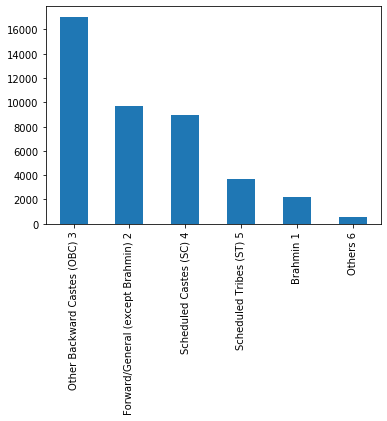

In [167]:
ihds_demo['Caste'].value_counts().plot.bar()

In [168]:
ihds_demo_array = ihds_demo.columns.tolist()

### 3. Education

1. I will work with Highest Male Education and Highest Female Education in Household. TAG has data on how much the girl's mother and father studt so this might not be exactly relevant but let's go for it for now. There is also data on highest overall adult education. But for now I have made the choice to work with male/female.

In [169]:
ihds_ed = pd.DataFrame(data={"Highest Male Education": ihds["hheducm"] \
                             ,"Highest Female Education": ihds["hheducf"] \
                            , "Highest Adult Education": ihds['hheduc']})

In [170]:
education_categories = np.array(ihds_ed['Highest Female Education'].value_counts().index.categories)

In [171]:
ihds_ed.replace(to_replace=education_categories, value=np.arange(0, 17), inplace=True)

Creating Array of Column names for education.

In [172]:
ihds_ed_array = ihds_ed.columns.tolist()

Text(0.5, 1, 'Education Features Heatmap')

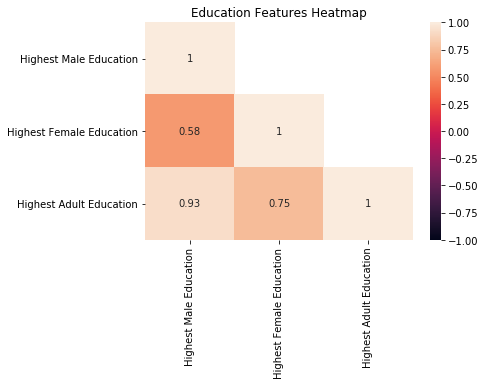

In [173]:
corr_ihds_ed = ihds_ed.corr()
corr_ihds_ed = corr_ihds_ed.where(np.tril(np.ones(corr_ihds_ed.shape)).astype(np.bool))
sns.heatmap(corr_ihds_ed, vmin=-1, vmax=1, annot=True)
plt.title("Education Features Heatmap")

### 4. Occupation

Note: TAG does not have occupation data.


## Income: Response Variable

In [174]:
hh_income = ihds['income']

In [175]:
print("Income Count: " + str(hh_income.count()))
print("Income Mean: " + str(hh_income.mean()))
print("Income Std: " + str(hh_income.std()))
print("Income Min: "+ str(hh_income.min()))
print("Income 25 Percentile: " + str(np.percentile(hh_income, 25)))
print("Income 50 Percentile: " + str(np.percentile(hh_income, 50)))
print("Income 75 Percentile: " + str(np.percentile(hh_income, 75)))
print("Income Max: " + str(hh_income.max()))

Income Count: 42152
Income Mean: 127759.76773232884
Income Std: 216673.37350338502
Income Min: -1037040.0
Income 25 Percentile: 39000.0
Income 50 Percentile: 73500.0
Income 75 Percentile: 144000.0
Income Max: 11360000.0


In [176]:
hh_income_percentiles = pd.qcut(hh_income, 100, labels=np.arange(1, 101))
hh_income_deciles = pd.qcut(hh_income, 10, labels=np.arange(1, 11))
hh_income_quartiles = pd.qcut(hh_income, 4, labels = np.arange(1, 5))

In [177]:
ihds['income'].mean()

127759.76773232884

In [178]:
mean_per_percentile = pd.DataFrame(data={"Income": hh_income, "Income Percentiles": hh_income_percentiles}).groupby("Income Percentiles").mean()

Text(0.5, 1.0, 'Mean Yearly Income for Every Percentile from IHDS (2012) survey')

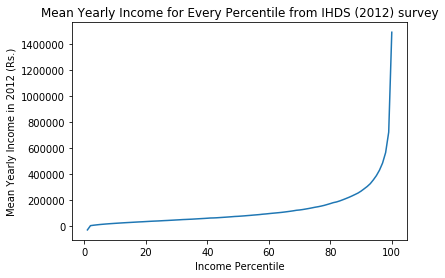

In [179]:
#fig = plt.figure(figsize=(5,5))
sns.lineplot(x=np.arange(1, 101), y=mean_per_percentile["Income"])
plt.xlabel("Income Percentile")
plt.ylabel("Mean Yearly Income in 2012 (Rs.)")
plt.title("Mean Yearly Income for Every Percentile from IHDS (2012) survey") # You could improve that

## Inference methods

In [180]:
ihds_features = pd.concat([ihds_assets, ihds_demo, ihds_ed], axis=1)

In [181]:
ihds_features['Income Quartiles'] = hh_income_quartiles
ihds_features['Income Deciles'] = hh_income_deciles
ihds_features['Income Percentiles'] = hh_income_percentiles
ihds_features['Income'] = ihds['income']

In [182]:
ihds_features.dropna(inplace=True)

In [183]:
ihds_train, ihds_test = train_test_split(ihds_features, test_size=0.25, random_state=42)

In [184]:
Y_perc_train = ihds_train['Income Percentiles']
Y_dec_train = ihds_train['Income Deciles']
Y_quar_train = ihds_train['Income Quartiles']
Y_train = ihds_train['Income']
X_train = ihds_train.drop(['Income Percentiles', 'Income', 'Income Deciles', 'Income Quartiles'], axis=1)

In [185]:
print("Number of Observations: " + str(len(X_train)))

Number of Observations: 28505


## Feature Engineering

In [186]:
def percentile_25(x):
    return np.percentile(x, 25)

In [187]:
def t_stat(x):
    if np.std(x) > 0:
        return np.mean(x) / np.std(x)

### Household Assets

Read the Following Paper: https://www-jstor-org.libproxy.berkeley.edu/stable/pdf/10.1086/671423.pdf

#### Additional Features that we can add: <br>
**[a]** Number of Household Assets Available <br>
**[b]** Weighted Score depending on Qualitative Analysis of Household Assets

In [188]:
X_train[ihds_demo_array]

,State,Urban/Rural,Religion,Caste
28204,Gujarat 24,rural 0,Hindu 1,Forward/General (except Brahmin) 2
11626,Uttar Pradesh 09,rural 0,Hindu 1,Scheduled Castes (SC) 4
29616,Maharashtra 27,urban 1,Hindu 1,Other Backward Castes (OBC) 3
14852,Bihar 10,urban 1,Hindu 1,Other Backward Castes (OBC) 3
950,Himachal Pradesh 02,rural 0,Hindu 1,Forward/General (except Brahmin) 2
...,...,...,...,...
18846,West Bengal 19,urban 1,Hindu 1,Scheduled Castes (SC) 4
6953,Delhi 07,urban 1,Hindu 1,Other Backward Castes (OBC) 3
12552,Uttar Pradesh 09,rural 0,Hindu 1,Other Backward Castes (OBC) 3
988,Himachal Pradesh 02,rural 0,Hindu 1,Brahmin 1


In [189]:
ihds_relevant_assets = copy.deepcopy(ihds_asset_array)

In [190]:
ihds_asset_array.append("Income Deciles")

In [191]:
ihds_train_assets = ihds_train[ihds_asset_array]

In [192]:
ihds_asset_array.remove("Income Deciles")

Does the monotonicity assumption hold?

In [193]:
X_train['num_assets'] = X_train[ihds_relevant_assets].sum(axis=1)

In [194]:
ihds_asset_response = copy.deepcopy(ihds_train_assets)

In [195]:
ihds_summary = ihds_asset_response.groupby('Income Deciles').agg(lambda x: sum(x)/len(x))

In [196]:
def wealth_score(row):
    return np.sum(np.multiply(np.array(row[ihds_asset_array]), asset_weight_array))

In [197]:
ihds_asset_response['Y_dec'] = Y_dec_train

In [198]:
asset_weight_array = np.array(np.std(ihds_summary))
asset_weight_array

array([0.08776646, 0.22101575, 0.13561501, 0.15113454, 0.00612324,
       0.21670621, 0.13313747, 0.13362294, 0.08157036, 0.10093447,
       0.22908899, 0.13681022, 0.12376127, 0.1003885 , 0.02587671,
       0.2027478 , 0.07509825])

In [199]:
X_train['wealth score'] = X_train[ihds_asset_array].apply(wealth_score, axis=1)

### Education

In [200]:
education_plots = copy.deepcopy(X_train[ihds_ed_array])

In [201]:
education_plots['Income'] = Y_train
education_plots['Income Percentiles'] = pd.to_numeric(Y_perc_train)                                      

In [202]:
education_plots.groupby("Highest Male Education")

In [203]:
education_plots.groupby(ihds_ed_array) \
.agg([np.mean, np.std, len, percentile_25, t_stat])

Income  \
                                                                                  mean   
Highest Male Education Highest Female Education Highest Adult Education                  
0.0                    0.0                      0.0                       60728.366395   
                       1.0                      1.0                       53735.894737   
                       2.0                      2.0                       59437.759259   
                       3.0                      3.0                       56208.956522   
                       4.0                      4.0                       59603.513274   
...                                                                                ...   
16.0                   12.0                     16.0                     287266.581522   
                       13.0                     16.0                     214600.615385   
                       14.0                     16.0                     244800.545455   
                       15.0                     16.0                     344507.733660   
                       16.0                     16.0                     507870.818859   

                                                                                        \
                                                                                   std   
Highest Male Education Highest Female Education Highest Adult Education                  
0.0                    0.0                      0.0                       80847.095124   
                       1.0                      1.0                       37437.132706   
                       2.0                      2.0                       30767.160604   
                       3.0                      3.0                       38803.952929   
                       4.0                      4.0                       59918.946177   
...                                                                                ...   
16.0                   12.0                     16.0                     236942.415296   
                       13.0                     16.0                      88857.699034   
                       14.0                     16.0                     147637.117148   
                       15.0                     16.0                     314259.261515   
                       16.0                     16.0                     470858.160949   

                                                                                 \
                                                                            len   
Highest Male Education Highest Female Education Highest Adult Education           
0.0                    0.0                      0.0                      3931.0   
                       1.0                      1.0                        19.0   
                       2.0                      2.0                        54.0   
                       3.0                      3.0                        69.0   
                       4.0                      4.0                       113.0   
...                                                                         ...   
16.0                   12.0                     16.0                      184.0   
                       13.0                     16.0                       13.0   
                       14.0                     16.0                       33.0   
                       15.0                     16.0                      306.0   
                       16.0                     16.0                      403.0   

                                                                                       \
                                                                        percentile_25   
Highest Male Education Highest Female Education Highest Adult Education                 
0.0                    0.0                      0.0                           26127.0   
                       1.0             

### Demographics

In [204]:
demographic_plots = X_train[ihds_demo_array]

In [205]:
demographic_plots['Income Percentiles'] = pd.to_numeric(Y_perc_train)

/Users/vatsalbajaj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [206]:
demographic_plots[['Urban/Rural', 'Religion', 'Income Percentiles', 'Caste']] \
.groupby(["Urban/Rural", 'Religion', 'Caste']).agg([np.mean, np.std, len])

Income Percentiles  \
                                                                      mean   
Urban/Rural Religion Caste                                                   
rural 0     Hindu 1  Brahmin 1                                   52.496741   
                     Forward/General (except Brahmin) 2          54.151104   
                     Other Backward Castes (OBC) 3               43.431794   
                     Scheduled Castes (SC) 4                     42.326903   
                     Scheduled Tribes (ST) 5                     33.856800   
...                                                                    ...   
urban 1     None 9   Forward/General (except Brahmin) 2          64.000000   
                     Other Backward Castes (OBC) 3                     NaN   
                     Scheduled Castes (SC) 4                     91.000000   
                     Scheduled Tribes (ST) 5                     69.500000   
                     Others 6                                          NaN   

                                                                            
                                                               std     len  
Urban/Rural Religion Caste                                                  
rural 0     Hindu 1  Brahmin 1                           30.004563   767.0  
                     Forward/General (except Brahmin) 2  29.577418  2581.0  
                     Other Backward Castes (OBC) 3       27.617728  6473.0  
                     Scheduled Castes (SC) 4             24.803089  3836.0  
                     Scheduled Tribes (ST) 5             24.151708  1669.0  
...                                                            ...     ...  
urban 1     None 9   Forward/General (except Brahmin) 2        NaN     1.0  
                     Other Backward Castes (OBC) 3             NaN     NaN  
                     Scheduled Castes (SC) 4                   NaN     1.0  
                     Scheduled Tribes (ST) 5             28.629821     4.0  
                     Others 6                                  NaN     NaN  

[108 rows x 3 columns]

## Models

In [207]:
def make_scorer(metric):
    return lambda model, x, y: metric(y, model.predict(x))

### Linear Regression

In [208]:
import statsmodels.api as sm

In [209]:
def make_linear_scorer(metric):
    return lambda model, x, y: metric(y, np.round(model.predict(x)))

In [212]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ihds_demo_array)
    ],
        remainder='passthrough'
    )


pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])


In [213]:
X = copy.deepcopy(X_train)
X['Y_dec_train'] = Y_dec_train
std_errors = X[['Y_dec_train', 'wealth score']].groupby('Y_dec_train').agg(np.std)
X = X[['Y_dec_train', 'wealth score']].groupby('Y_dec_train').agg(np.mean)

In [214]:
std_errors

,wealth score
Y_dec_train,
1,0.474122
2,0.414096
3,0.426246
4,0.425058
5,0.430603
6,0.428423
7,0.427835
8,0.416613
9,0.403011


Text(0, 0.5, 'Wealth Score')

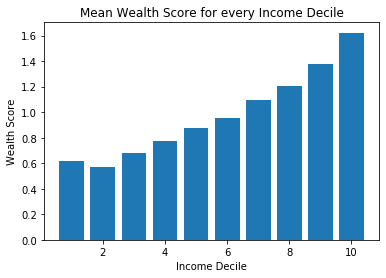

In [215]:
plt.bar(X.index.tolist(), X['wealth score'])
plt.title("Mean Wealth Score for every Income Decile")
plt.xlabel("Income Decile")
plt.ylabel("Wealth Score")

In [216]:
X_train_ols = X_train.copy(deep=True)

In [217]:
append_df_ols = pd.get_dummies(X_train_ols[ihds_demo_array])

In [218]:
X_train_ols.drop(ihds_demo_array, inplace=True, axis=1)

In [219]:
X_train_ols = pd.concat([X_train_ols, append_df_ols], axis=1)

In [220]:
features = ['Highest Adult Education', 'num_assets', 'wealth score',
            "Urban/Rural_rural 0", 'Chair/Table', 'Color TV', 'Computer/Laptop', 'Refrigerator', 'Car',
           "Caste_Forward/General (except Brahmin) 2", "Religion_Muslim 2"]
X_select = copy.deepcopy(X_train_ols[features])
X_select = sm.add_constant(X_select)

### OLS

In [225]:
lr_model = sm.OLS(Y_dec_train.astype(np.int), X_select.astype(np.int), hasconst=True)
results = lr_model.fit()
print("Parameters:\n", results.params)
print("Regression Table: \n", results.summary())

with open('summary.txt', 'w') as fh:
    fh.write(results.summary().as_text())

Parameters:
 const                                       2.723629
Highest Adult Education                     0.068319
num_assets                                  0.277516
wealth score                                0.145816
Urban/Rural_rural 0                        -0.404606
Chair/Table                                -0.016724
Color TV                                    0.400952
Computer/Laptop                             0.284136
Refrigerator                                0.570492
Car                                         0.382638
Caste_Forward/General (except Brahmin) 2    0.195221
Religion_Muslim 2                           0.093765
dtype: float64
Regression Table: 
                             OLS Regression Results                            
Dep. Variable:         Income Deciles   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     1544.


In [226]:
pred_income_deciles = np.round(results.predict())

In [229]:
metrics.mean_squared_error(pred_income_deciles, Y_dec_train)

5.136818102087353

In [230]:
metrics.accuracy_score(pred_income_deciles, Y_dec_train)

0.15955095597263638

In [231]:
metrics.r2_score(pred_income_deciles, Y_dec_train)

-0.6603891152730246

### SKLearn

In [232]:
pipeline_lr.fit(X_train, Y_dec_train)
pred_linear = pipeline_lr.predict(X_train)

In [233]:
lr_model = pipeline_lr.named_steps['model']

In [234]:
print(lr_model.intercept_)
print(list(zip(X_train.columns, lr_model.coef_)))

-683367.6799402251
[('Electricity', -0.6036012294398798), ('Pressure Cooker', 1.653244814381976), ('Chair/Table', 0.1585752291395317), ('Electric Fan', -0.39206379593418694), ('Black and White TV', -0.023231768948972054), ('Color TV', -1.1807657085078183), ('Sewing Machine', -0.5828429219444353), ('Mobile Telephone', -0.3244639016515831), ('Landline Telephone', 0.029449861645696573), ('Computer/Laptop', -0.36835817933184856), ('Refrigerator', -0.5786666244132516), ('AC', 0.047463602419277384), ('Washing Machine', 0.38240793130990863), ('Watch/Clock', 0.697165072628777), ('Bicycle', -0.8608191356596022), ('Motorcycle/Scooter', -0.07366369660533878), ('Car', 0.2767098450270319), ('State', -0.729107986063243), ('Urban/Rural', -0.10259588214782411), ('Religion', 0.5132853918945078), ('Caste', 1.7461581424801027), ('Highest Male Education', 1.0986156735448036), ('Highest Female Education', 0.27668757162532814), ('Highest Adult Education', -0.7860795850738231), ('num_assets', -0.210192759852

In [235]:
pipeline_lr.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                     transformer_weights=None,
                     transformers=[('cat',
                                    Pipeline(memory=None,
                                             steps=[('onehot',
                                                     OneHotEncoder(categories='auto',
                                                                   drop=None,
                                                                   dtype=<class 'numpy.float64'>,
                                                                   handle_unknown='ignore',
                                                                   sparse=True))],
                                             verbose=False),
                                    ['State', 'Urban/Rural', 'Religion',
                                     'Caste'])],
                     verbose=False)),
  ('m

In [236]:
metrics.mean_squared_error(Y_dec_train, pred_linear)

4.81174606921548

In [237]:
metrics.r2_score(Y_dec_train, pred_linear)

0.40378595237156045

In [238]:
metrics.accuracy_score(pred_income_deciles, Y_dec_train)

0.15955095597263638

In [239]:
np.mean(cross_val_score(pipeline_lr, X_train, Y_dec_train, 
                            scoring=make_linear_scorer(metrics.accuracy_score), 
                            cv=5))

0.16621645325381512

In [240]:
np.mean(cross_val_score(pipeline_lr, X_train, Y_dec_train, 
                            scoring=make_linear_scorer(metrics.r2_score), 
                            cv=5))

0.3902499910528531

In [241]:
pred_income_percentiles = pd.qcut(pred_linear, 4, labels=np.arange(1, 5))

### Logistic Regression

In [242]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ihds_demo_array)
    ],
        remainder='passthrough'
    )

pipeline = Pipeline(
    [
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=42))
    ]
)

In [243]:
#logistic_model = LogisticRegression(max_iter=100, class_weight='balanced', solver='sag')
pipeline.fit(X_train, Y_dec_train)
pred_logistic = pipeline.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_dec_train,pred_logistic))

Training Accuracy:  0.23873004736011227


/Users/vatsalbajaj/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [244]:
metrics.r2_score(Y_dec_train, pred_logistic)

0.11536045920793492

In [245]:
np.mean(cross_val_score(pipeline, X_train, Y_dec_train, 
                            scoring=make_scorer(metrics.accuracy_score), 
                            cv=5))

/Users/vatsalbajaj/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/vatsalbajaj/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

0.22624101034906158

In [246]:
np.mean(cross_val_score(pipeline, X_train, Y_dec_train, 
                            scoring=make_scorer(metrics.r2_score), 
                            cv=5))

/Users/vatsalbajaj/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/vatsalbajaj/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

0.10948176456001871

### Decision Tree

In [247]:
X_train_tree = X_train.copy(deep=True)

In [248]:
append_df = pd.get_dummies(X_train_tree)

In [249]:
X_train_tree.drop(ihds_demo_array, inplace=True, axis=1)

In [250]:
X_train_tree = pd.concat([X_train_tree, append_df], axis=1)

In [251]:
from sklearn import tree

pipeline = Pipeline(steps=[
    ('model', tree.DecisionTreeClassifier(max_depth=4))
])

In [252]:
dt_model = pipeline['model']

In [253]:
pipeline.fit(X_train_tree, Y_dec_train)

Pipeline(memory=None,
         steps=[('model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=4,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [254]:
tree_pred = pipeline.predict(X_train_tree)

In [255]:
class_names = np.arange(1, 11)
class_names = [str(c) for c in class_names]

In [256]:
features = np.array(X_train_tree.columns)

In [257]:
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');
import matplotlib.pyplot as plt
import seaborn as sns

In [258]:
# import graphviz
# dot_data = tree.export_graphviz(dt_model, out_file=None, 
#                       feature_names=features,  
#                       class_names=class_names,  
#                       filled=True, rounded=True,  
#                       special_characters=True, proportion = True)  
# graph = graphviz.Source(dot_data)
# graph.render(format="png", filename="education_depth_4") # Weird error with demography?
# graph

### Random Forest Classifier

In [259]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

In [260]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ihds_demo_array)
    ],
        remainder='passthrough'
    )

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier())
])

In [261]:
X_train.columns

Index(['Electricity', 'Pressure Cooker', 'Chair/Table', 'Electric Fan',
       'Black and White TV', 'Color TV', 'Sewing Machine', 'Mobile Telephone',
       'Landline Telephone', 'Computer/Laptop', 'Refrigerator', 'AC',
       'Washing Machine', 'Watch/Clock', 'Bicycle', 'Motorcycle/Scooter',
       'Car', 'State', 'Urban/Rural', 'Religion', 'Caste',
       'Highest Male Education', 'Highest Female Education',
       'Highest Adult Education', 'num_assets', 'wealth score'],
      dtype='object')

In [262]:
pipeline.fit(X_train, Y_dec_train)
rf_pred = pipeline.predict(X_train)
metrics.accuracy_score(rf_pred, Y_dec_train)

0.9325030696369058

In [263]:
np.mean(cross_val_score(pipeline, X_train, Y_dec_train, 
                            scoring=make_scorer(metrics.accuracy_score), 
                            cv=5))

0.19901771619014208

In [264]:
import pylab as pl

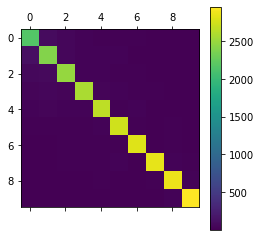

In [265]:
cm = confusion_matrix(Y_dec_train, rf_pred)
pl.matshow(cm)
#pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

In [266]:
print(classification_report(pipeline.predict(X_train), Y_quar_train))

              precision    recall  f1-score   support

           1       0.36      0.94      0.52      2491
           2       0.02      0.05      0.03      2732
           3       0.01      0.02      0.01      2736
           4       0.00      0.01      0.00      2797
           5       0.00      0.00      0.00      2875
           6       0.00      0.00      0.00      2930
           7       0.00      0.00      0.00      2956
           8       0.00      0.00      0.00      2950
           9       0.00      0.00      0.00      2990
          10       0.00      0.00      0.00      3048

    accuracy                           0.09     28505
   macro avg       0.04      0.10      0.06     28505
weighted avg       0.03      0.09      0.05     28505



/Users/vatsalbajaj/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



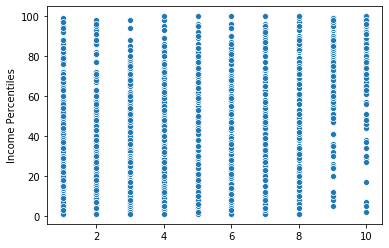

In [279]:
sns.scatterplot(x=rf_pred, y=Y_perc_train)

In [280]:
metrics.r2_score(Y_train, rf_pred)

-0.3792732349743939

In [281]:
np.mean(cross_val_score(pipeline, X_train, Y_dec_train, 
                            scoring=make_scorer(metrics.accuracy_score), 
                            cv=5))

0.19891247149622876

In [282]:
np.mean(cross_val_score(pipeline, X_train, Y_quar_train, 
                            scoring=make_scorer(metrics.r2_score), 
                            cv=5))

0.004374180245370484

In [272]:
param_grid = {
    'model__n_estimators': np.arange(10, 200, 10), 
    'model__max_depth': np.arange(0, 100, 5), 
    'model__ccp_alpha': np.arange(0, 0.5, 0.1),
    'model__class_weight': ['balanced', None],
    'model__max_features': np.arange(1, 26),
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}

In [273]:
search = RandomizedSearchCV(
    estimator = pipeline,
    param_distributions = param_grid,
    n_iter = 100,
    n_jobs=-1, 
    scoring='accuracy',
    cv=3,
    verbose=3,
    pre_dispatch='n_jobs'
)

In [275]:
search.fit(X_train, Y_quar_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='passthrough',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('cat',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('onehot',
                                                                                                OneHotEncoder(categories='auto',
                                                                                 

In [276]:
search.best_params_

{'model__n_estimators': 60,
 'model__min_samples_split': 10,
 'model__min_samples_leaf': 4,
 'model__max_features': 3,
 'model__max_depth': 15,
 'model__class_weight': None,
 'model__ccp_alpha': 0.0,
 'model__bootstrap': True}

In [277]:
search.best_score_

0.472829341659509

### Accuracy Table

| Sample | Granularity | Num Features | Max Depth | CCP_alpha | N_estimators | Best Accuracy Score |
| --- | --- | --- | --- | --- | --- | --- |
| Full | Percentiles | 25 | 5 | 0 | 160 | 2.91 % |
| Full | Deciles | 23 | 10 | 0 | 110 | 22.1 % |
| Full | Quartiles | 23 | 10 | 0 | 10 | 46.4 % |
| Teenage Girl HH | Percentiles | 25 | 5 | 0 | 110 | 2.8% |
| Teenage Girl HH | Deciles | 18 | 5 | 0 | 60 | 20.5% |
| Teenage Girl HH | Quartiles | 24 | 10 | 0 | 160 | 45.2% |